<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/Bert_FCNN/FakeNewsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [5]:
!git clone https://github.com/AnastasiaKazanas/ANN-Final-Project.git

Cloning into 'ANN-Final-Project'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 362 (delta 114), reused 190 (delta 99), pack-reused 85 (from 1)
Receiving objects: 100% (362/362), 61.57 MiB | 19.94 MiB/s, done.
Resolving deltas: 100% (161/161), done.
Filtering content: 100% (4/4), 435.85 MiB | 35.58 MiB/s, done.


In [14]:
file_path = '/content/ANN-Final-Project/Bert_embeding_datasets/Fake_News_Classification.h5'

with h5py.File(file_path, 'r') as f:
    input_ids = np.array(f['input_ids'])
    attention_masks = np.array(f['attention_mask'])
    labels = np.array(f['labels'])
    texts = np.array(f['texts'])

# Convert to PyTorch tensors
input_ids = torch.tensor(input_ids, dtype=torch.float32)
attention_masks = torch.tensor(attention_masks, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42
)

# Create Tensor datasets and Data loaders
train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train)
test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
class BertFCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BertFCNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        # Combine input_ids and attention_mask if necessary
        combined_input = input_ids + attention_mask  # This is an example; modify as needed
        return self.fc(combined_input)

# Model parameters
input_size = input_ids.shape[1]  # Number of features in BERT embeddings
hidden_size = 128
num_classes = 2  # Fake or True
model = BertFCNN(input_size, hidden_size, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/5, Loss: 80.7798
Epoch 2/5, Loss: 2.2684
Epoch 3/5, Loss: 1.1029
Epoch 4/5, Loss: 0.8240
Epoch 5/5, Loss: 0.6933
Accuracy on the test set: 0.58


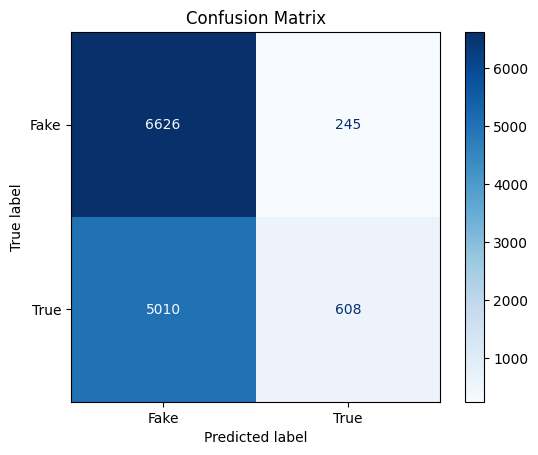

In [16]:
# Train the model
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for input_ids_batch, mask_batch, labels_batch in train_loader:
        outputs = model(input_ids_batch, mask_batch)
        loss = criterion(outputs, labels_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for input_ids_batch, mask_batch, labels_batch in test_loader:
        outputs = model(input_ids_batch, mask_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.tolist())
        all_targets.extend(labels_batch.tolist())
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Fake', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()